# Proposal of an anomaly detection solution for Transportico
Authors : Raoul NH (raoul.ngayamhappy@gmail.com)

## 1. Problem statement
Transportico is a transport company carrying food products between two warehouses.

**The company needs to identify anomalies (i.e. unusual activities) that might happen in transporting events**.

For this a dataset of recorded events over a period of 3 months has been provided.

Transportico has also provided a set of rules to be used to trigger anomalous evens. In addition, based on a finer exploration of the data, other anomalies might be spotted.

## 2. Methodology
Anomaly detection: refers to identifying unusual or unexpected patterns or data points in a dataset

Steps:
- Basic data exploration and cleaning
- Anomaly detection using pre-defined client rules
- Anomaly detection using advanced EDA
- Anomaly detection using Statistical / ML techniques

Output should be actionable to be used --> View per day of anomalies + detailed view at day level

## 3. Import used libraries
The study has been carried out using most common data analysis, data visualization and ML libraries: pandas, pandas_profiling, numpy, matplotlib, seaborn, 

If not available on your environment, make sure you install them by copying and executing the following commands:

```
!pip install pandas
```
```
!pip install pandas_profiling[notebook]
```
```
!pip install plotly
```
```
!pip install geopy
```

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import geopy.distance
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_6318/2548928731.py:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


## 4. Basic data understanding
The objective is to have at first glance an overview of the data (shape, types, missing values, distribution).

There are 2 general ways to perform this analysis:
- Using pandas functions like shape, dtypes, info, describe
- Using built-in libraries like pandas_profiling, autoviz, dataprep (these libraries provide more detailed info)

### 4.1 Using pandas functions

In [2]:
(
    pd.read_csv("../data/scenarios.csv")
    .head()
)

_source/data/positionData  _source/data/speedData  \
0     [12.67214, 108.06884]                    0.00   
1     [12.65841, 108.03907]                   54.95   
2     [12.61997, 107.95092]                   47.81   
3     [12.58494, 107.87112]                   60.87   
4     [12.54409, 107.79773]                   43.06   

  _source/data/unit_speedData  _source/data/temperatureData  \
0                         KMH                          5.50   
1                         KMH                          2.04   
2                         KMH                          2.96   
3                         KMH                          2.45   
4                         KMH                          2.17   

   _source/data/lightData _source/data/recorded_at  \
0                     200      2023-01-01 14:00:00   
1                       0      2023-01-01 14:13:30   
2                       0      2023-01-01 14:27:00   
3                       0      2023-01-01 14:40:30   
4                       0      2023-01-01 14:54:00   

  _source/data/unit_temperatureData _source/data/unit_lightData  \
0                               CEL                         LUX   
1                               CEL                         LUX   
2                               CEL                         LUX   
3                               CEL                         LUX   
4                               CEL                         LUX   

  _source/data/eventType _source/data/action   _source/data/eventID  
0            ObjectEvent             OBSERVE  xrlYlV1Pcv_vO_8n4JPyi  
1            ObjectEvent             OBSERVE  dkA2V7_H1L-ZewTbeJbQP  
2            ObjectEvent             OBSERVE  sfUc0dftAes27cZZ4112_  
3            ObjectEvent             OBSERVE  KLECMdIVRtZ6Yqs2lgWsN  
4            ObjectEvent             OBSERVE  ZMiTvOwYlM3bNEgkVy47p

>```The dataset contains a list of recorded events with the following information for each event: event ID, recorded position, recorded date and time, recorded speed of the truck and corresponding unit, recorded temperature in the trailer and corresponding unit, recorded light in the trailer and corresponding unit, event type and action.```

In [3]:
(
    pd.read_csv("../data/scenarios.csv")
    .info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3415 entries, 0 to 3414
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _source/data/positionData          3415 non-null   object 
 1   _source/data/speedData             3415 non-null   float64
 2   _source/data/unit_speedData        3415 non-null   object 
 3   _source/data/temperatureData       3415 non-null   float64
 4   _source/data/lightData             3415 non-null   int64  
 5   _source/data/recorded_at           3415 non-null   object 
 6   _source/data/unit_temperatureData  3415 non-null   object 
 7   _source/data/unit_lightData        3415 non-null   object 
 8   _source/data/eventType             3415 non-null   object 
 9   _source/data/action                3415 non-null   object 
 10  _source/data/eventID               3415 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 293.6+ 

>```
>There are 3415 event entries in the dataset and none is missing a data point, i.e. no need to deal with missing values (deletion, imputation, ...)
>```
>```
>Speed, temperature and light data are numerical, which is consistent with expected. 
>```
>```
>Time of record should be a datetime type. Position data show latitude and longitude but is of object type. 
>For these 2, extra treatment is needed to transform the data to a compliant format.
>```

In [4]:
(
    pd.read_csv("../data/scenarios.csv")
    .nunique()
)

_source/data/positionData             188
_source/data/speedData               2423
_source/data/unit_speedData             1
_source/data/temperatureData          598
_source/data/lightData                  3
_source/data/recorded_at             3410
_source/data/unit_temperatureData       1
_source/data/unit_lightData             1
_source/data/eventType                  1
_source/data/action                     1
_source/data/eventID                 3415
dtype: int64

>```
>All three units data show a unique value, which means that all values for each measure are of the same unit (Km/h, °C and Lux respectively for speed, temperature and light)
>```
>```
>Event type and action show also a unique value and therefore do not discriminate between events.
>```
>```
>These five features can be deleted.
>```

### 4.2 Using built-in libraries
In the example below, pandas_profiling has been used. It provides basic data analysis info in a more user friendly way via a dashboard. 

Same conclusions as above can be drawn

In [5]:
ProfileReport(pd.read_csv("../data/scenarios.csv"), title="Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 5. Data preparation
The objective is to apply some transformations on the data to prepare them for further analysis.

Here are all transformations applied:
- Splitting location coordinates into latitute and longitude features
- Extracting date and time features from recorded datetime
- Dropping useless columns
- Changing data types
- Reindexing columns
- Renaming columns

In [6]:
def prepare_data(data: pd.DataFrame) -> pd.DataFrame:
    """Prepare raw dataframe

        :param data: input DataFrame
        :returns: transformed DataFrame

    """

    return (
        data.copy()
        .assign(
            **{
                "Latitude": lambda df_: df_["_source/data/positionData"].str.split(',').str[0].str.replace("[", ""),
                "Longitude": lambda df_: df_["_source/data/positionData"].str.split(',').str[1].str.replace("]", ""),
                "Date": lambda df_: pd.to_datetime(df_["_source/data/recorded_at"]).dt.date,
                "Time": lambda df_: pd.to_datetime(df_["_source/data/recorded_at"]).dt.time,
                "Hour": lambda df_: pd.to_datetime(df_["_source/data/recorded_at"]).dt.hour,
                "Minute": lambda df_: pd.to_datetime(df_["_source/data/recorded_at"]).dt.minute,
                "TimeMinutes": lambda df_: df_["Hour"] * 60 + df_["Minute"]
            }
        )
        .drop(
            ["_source/data/positionData", 
            "_source/data/unit_speedData", 
            "_source/data/unit_temperatureData", 
            "_source/data/unit_lightData", 
            "_source/data/eventType", 
            "_source/data/action"], 
            axis=1
        )
        .astype(
            {
                "_source/data/recorded_at": "datetime64[ns]",
                "Date": "datetime64[ns]",
                "Latitude": "float",
                "Longitude": "float"
            }
        )
        .sort_values(
            by=["_source/data/recorded_at"]
        )
        .reindex(
            columns=[
                "_source/data/eventID", 
                "_source/data/recorded_at",
                "Date",
                "Time",
                "TimeMinutes",
                "Hour",
                "Minute",
                "Latitude",
                "Longitude",
                "_source/data/speedData",
                "_source/data/temperatureData",
                "_source/data/lightData"
            ]
        )
        .rename(
            columns={
            "_source/data/eventID": "ID", 
            "_source/data/recorded_at": "Datetime",
            "_source/data/speedData": "Speed",
            "_source/data/temperatureData": "Temperature",
            "_source/data/lightData": "Light"
            }
        )
    )

Below is the dataframe obtained after applying above transformations

In [7]:
(
    prepare_data(pd.read_csv("../data/scenarios.csv"))
)

ID            Datetime       Date      Time  \
0     xrlYlV1Pcv_vO_8n4JPyi 2023-01-01 14:00:00 2023-01-01  14:00:00   
1     dkA2V7_H1L-ZewTbeJbQP 2023-01-01 14:13:30 2023-01-01  14:13:30   
2     sfUc0dftAes27cZZ4112_ 2023-01-01 14:27:00 2023-01-01  14:27:00   
3     KLECMdIVRtZ6Yqs2lgWsN 2023-01-01 14:40:30 2023-01-01  14:40:30   
4     ZMiTvOwYlM3bNEgkVy47p 2023-01-01 14:54:00 2023-01-01  14:54:00   
...                     ...                 ...        ...       ...   
2200  EuPgSWmLUnTNWUsrogwW8 2023-03-31 22:10:54 2023-03-31  22:10:54   
2201  A0UuE-SYVjw-tW1kBGgqT 2023-03-31 22:20:43 2023-03-31  22:20:43   
2202  AiNNqxc5csIY6mjs4Lm8Q 2023-03-31 22:30:32 2023-03-31  22:30:32   
2203  2owKdI7zpINnlIUGChvJ0 2023-03-31 22:40:21 2023-03-31  22:40:21   
2204  G8aLwFkqQWKz8cQTYwYHk 2023-03-31 22:50:10 2023-03-31  22:50:10   

      TimeMinutes  Hour  Minute  Latitude  Longitude  Speed  Temperature  \
0             840    14       0  12.67214  108.06884   0.00         5.50   
1             853    14      13  12.65841  108.03907  54.95         2.04   
2             867    14      27  12.61997  107.95092  47.81         2.96   
3             880    14      40  12.58494  107.87112  60.87         2.45   
4             894    14      54  12.54409  107.79773  43.06         2.17   
...           ...   ...     ...       ...        ...    ...          ...   
2200         1330    22      10  10.48768  107.16279  51.93         2.04   
2201         1340    22      20  10.51021  107.09660  37.26         0.01   
2202         1350    22      30  10.43127  107.15820  36.52         4.05   
2203         1360    22      40  10.39718  107.11183  86.67         3.50   
2204         1370    22      50  10.38960  107.08450   0.00         5.60   

      Light  
0       200  
1         0  
2         0  
3         0  
4         0  
...     ...  
2200      0  
2201      0  
2202      0  
2203      0  
2204    180  

[3415 rows x 12 columns]

## 6. Detailed exploration

The objective here is to further explore position features as well as measures (Speed, Temperature, Light) in order to get more insights

### 6.1 Number of records per date
The results show that 94% of dates (78 out of 83) have 40 event records. 
We will use these 78 dates as reference to analyze position, speed, temperature and light.

Detailed analysis of other values will be analyzed later

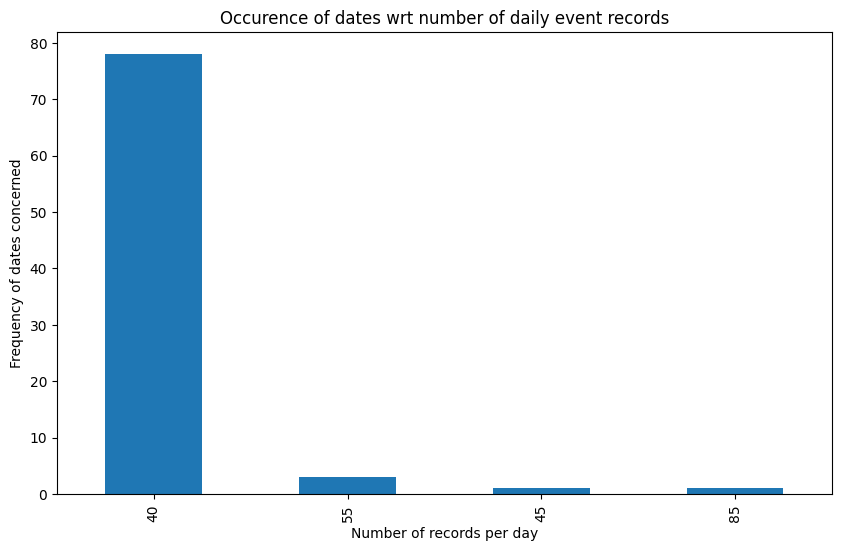

In [8]:
(
    prepare_data(pd.read_csv("../data/scenarios.csv"))
    .groupby(["Date"])[["Latitude"]]
    .count()
    .value_counts()
    .reset_index()
    .rename(columns={"Latitude": "Records", 0: "Freq"})
    .plot(
        x="Records", y="Freq",
        kind="bar", 
        xlabel="Number of records per day", 
        ylabel="Frequency of dates concerned",
        figsize=(10,6),
        legend=False,
        title="Occurence of dates wrt number of daily event records"
    )
)
plt.show()

### 6.2 Reference trip coordinates
Analysis of the mean coordinates of a reference trip (average latitude and longitude of each 40 record positions)
The results show that: 
- Reference coordinates at departure are {"LatitudeDeparture": 12.67214, "LongitudeDeparture": 108.06884} 
- Reference coordinates at arrival are {"LatitudeArrival": 10.38960, "LongitudeArrival": 107.08450}

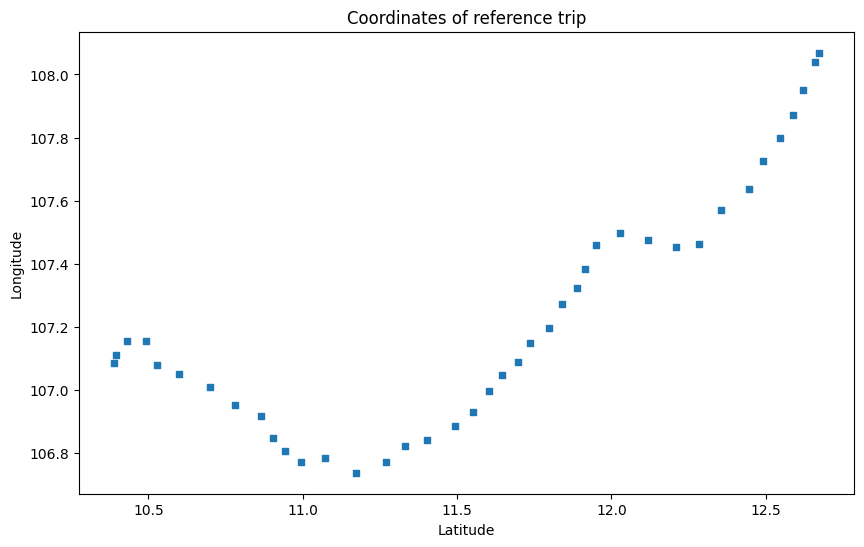

In [9]:
(
    prepare_data(pd.read_csv("../data/scenarios.csv"))
    .groupby(["Date"])[["Latitude"]].count().query("`Latitude` == 40")
    .merge(
        prepare_data(pd.read_csv("../data/scenarios.csv")),
        on="Date",
        how="left"
    )
    .drop(
        ["Latitude_x"],
        axis=1
    )
    .rename(columns={"Latitude_y": "Latitude"})
    .groupby(["Time"])[["Latitude", "Longitude"]]
    .agg(["mean"])
    .droplevel(1, axis=1).reset_index()
    .plot(
        x="Latitude", y="Longitude",
        kind="scatter", 
        marker="s",
        xlabel="Latitude", 
        ylabel="Longitude",
        figsize=(10,6),
        legend=False,
        title="Coordinates of reference trip"
    )
)
plt.show()

### 6.3 Reference trip measures
Analysis of the mean measures (mean speed, mean temperature, mean light) of a reference trip (data averaged at each record for all 78 reference dates)
The results show that main pertubations occur at departure and arrival
- At departure and arrival speed is = 0 and temperature is a bit lower than 6°C. Light is 200 Lux at departure (daylight) and a bit lower at arrival, i.e. 180 Lux (Night ?)
- During the trip the mean speed is ~45 Km/h, the mean temperature is ~3°C and the Light is 0 Lux

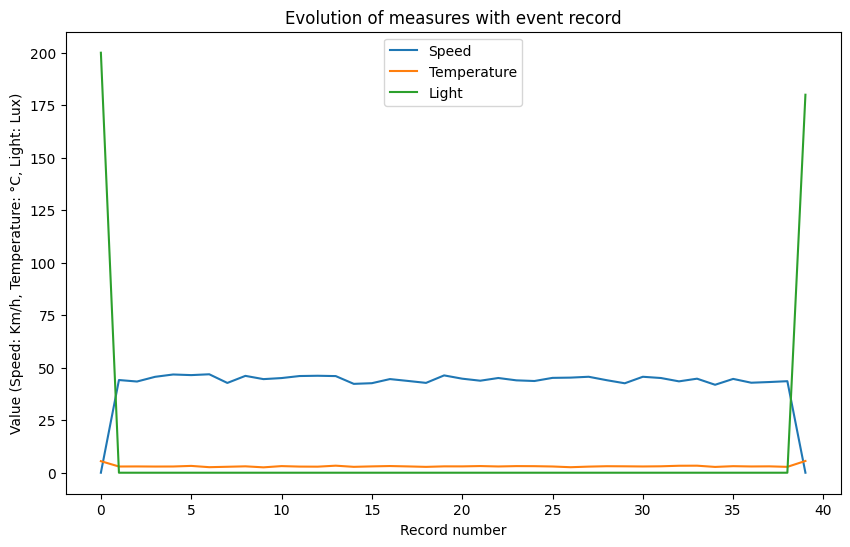

In [10]:
(
    prepare_data(pd.read_csv("../data/scenarios.csv"))
    .groupby(["Date"])[["Latitude"]].count().query("`Latitude` == 40")
    .merge(
        prepare_data(pd.read_csv("../data/scenarios.csv")),
        on="Date",
        how="left"
    )
    .drop(
        ["Latitude_x"],
        axis=1
    )
    .rename(columns={"Latitude_y": "Latitude"})
    .groupby(["Time"])[["Speed", "Temperature", "Light"]]
    .agg(["mean"])
    .droplevel(1, axis=1).reset_index()
    # .iloc[1:-1, :]
    # .mean()
    .plot(
        kind="line",
        xlabel="Record number", 
        ylabel="Value (Speed: Km/h, Temperature: °C, Light: Lux)",
        figsize=(10,6),
        title="Evolution of measures with event record"
    )
)
plt.show()

## 7. Rule-based anomaly detection
The objective here is to add to the dataset and for each event results of anomaly detection based on defined client rules on Speed, Temperature and Open doors (equivalent to light in the trailer). 

An additional check for Speed > 0 AND Light > 0 (Doors opened while driving has been added)

Each check is performed using a function that takes as input the transformed dataframe and return a the dataframe with a new column filled with 1 (Anomalous event) or 0 (Normal event)

### 7.0 Used functions

In [11]:
## SPEED ##

def check_speed_anomaly(data: pd.DataFrame) -> pd.DataFrame:
    """Add column with anomalies detected on speed data

        :param data: input DataFrame
        :returns: DataFrame with additional column with results of check

    """
    return (
        data.copy()
        .assign(
            **{
                "SpeedAnomaly": lambda df_: (df_["Speed"] > 80).astype("int")
                # "SpeedAnomaly": lambda df_: df_["Speed"].apply(lambda x: 1 if x > 80 else 0)
            }
        )
    )


## TEMPERATURE ##

def check_temperature_anomaly(data: pd.DataFrame) -> pd.DataFrame:
    """Add column with anomalies detected on temperature data

        :param data: input DataFrame
        :returns: DataFrame with additional column with results of check

    """
    return (
        data.copy()
        .assign(
            **{
                # "TemperatureAnomaly": lambda df_: df_["Temperature"] > 6
                "TemperatureAnomaly": lambda df_: df_["Temperature"].apply(lambda x: 1 if x > 6 else 0)
            }
        )
    )


## DOORS OPENED ##

def check_doors_anomaly(
    data: pd.DataFrame, 
    coordinates: dict, 
    tolerance: float
    ) -> pd.DataFrame:

    """Add column with anomalies detected on trailer door
       Doors are opened when Light > 0
       The anomalous case happens when 
       Light > 0 AND ((Latitude != Latitute at departure AND Longitude != Longitude at departure) (OR Latitude != Latitute at arrival AND Longitude != Longitude at arrival))
       

        :data: input DataFrame
        :coordinates: dictionary with coordinates as
        {
            "LatitudeDeparture": float,
            "LongitudeDeparture": float,
            "LatitudeArrival": float,
            "LongitudeArrival": float
        } 
        tolerance: tolerance such that 0 <= abs(Departure - arrival) <= tolerance

        :returns: DataFrame with additional column with results of check

    """
    def condition(row):
        light = row["Light"] > 0
        departure = (0.0 <= np.abs((row["Latitude"] + row["Longitude"]) - (coordinates["LatitudeDeparture"] + coordinates["LongitudeDeparture"])) <= tolerance)
        arrival = (0.0 <= np.abs((row["Latitude"] + row["Longitude"]) - (coordinates["LatitudeArrival"] + coordinates["LongitudeArrival"])) <= tolerance)
        
        if light:
            if (departure or arrival):
                return 0
            else: return 1
        if not light:
            return 0
            
    return (
        data.copy()
        .assign(
            **{
                "DoorsAnomaly": lambda df_: df_.apply(condition, axis=1)
            }
        )
    )


## CATASTROPHIC ##

def check_catastrophic_anomaly(data: pd.DataFrame) -> pd.DataFrame:
    """Add column with anomalies detected on catastrophic anomaly (light > 0 AND speed > 0, i.e doors opened while driving)

        :param data: input DataFrame
        :returns: DataFrame with additional column with results of check

    """
    return (
        data.copy()
        .assign(
            **{
                "CatastrophicAnomaly": lambda df_: [
                    1 if x > 0 and y > 0 else 0
                    for x, y in df_[["Speed", "Light"]].values
                    ]
            }
        )
    )

## COUNT OF ERRORS ##

def error_counts(data:pd.DataFrame) -> pd.DataFrame:
    """Add 2 columns that spot events with any 

        :param data: input DataFrame
        :returns: DataFrame with additional column with results of check

    """
    return (
        data.copy()
        .assign(
            **{"AnyAnomaly": lambda df_: [
                any(x)
                for x in df_[["SpeedAnomaly", "TemperatureAnomaly", "DoorsAnomaly", "CatastrophicAnomaly"]].values
                ],
                "MultipleAnomalies": lambda df_: [
                    sum(x) > 1
                    for x in df_[["SpeedAnomaly", "TemperatureAnomaly", "DoorsAnomaly", "CatastrophicAnomaly"]].values
                ]
            }
        )
        .astype(
            {
                "AnyAnomaly": "int",
                "MultipleAnomalies": "int"
            }
        )
    )

### 7.1 Anomalous speed events
Results show that anomalous speed events are observed at 3 specific dates with % of records concerned between 47% and 56%

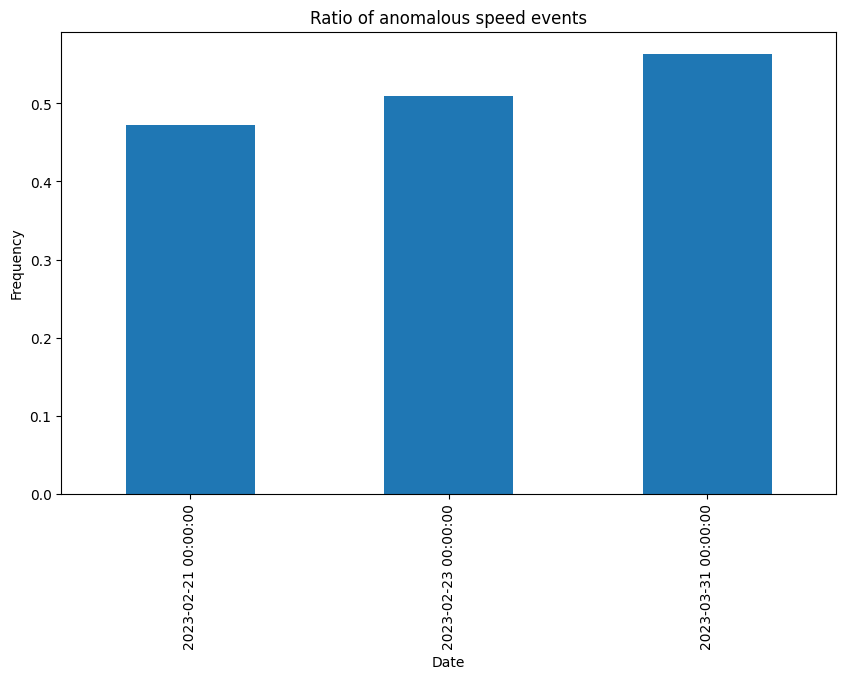

In [12]:
(
    prepare_data(pd.read_csv("../data/scenarios.csv"))
    .pipe(check_speed_anomaly)
    .query("`SpeedAnomaly` == 1")
    .groupby(["Date"])["SpeedAnomaly"]
    .agg(["sum"])
    .merge(
        prepare_data(pd.read_csv("../data/scenarios.csv"))
        .groupby(["Date"])["Speed"]
        .agg(["count"]),
        on="Date",
        how="left"
    )
    .reset_index()
    .assign(
        **{
            "Percentage": lambda df_: df_["sum"] / df_["count"]
        }
    )
    .plot(
        kind="bar",
        x="Date",
        y="Percentage",
        xlabel="Date", 
        ylabel="Frequency",
        legend=False,
        figsize=(10,6),
        title="Ratio of anomalous speed events"
    )
    # .transform("sum")
    # .query("'2023-02-21' == `Date`")
)
plt.show()

### 7.2 Anomalous temperature events
Results show that anomalous temperature events are observed at 2 specific dates with % of records concerned between 6% and 11%

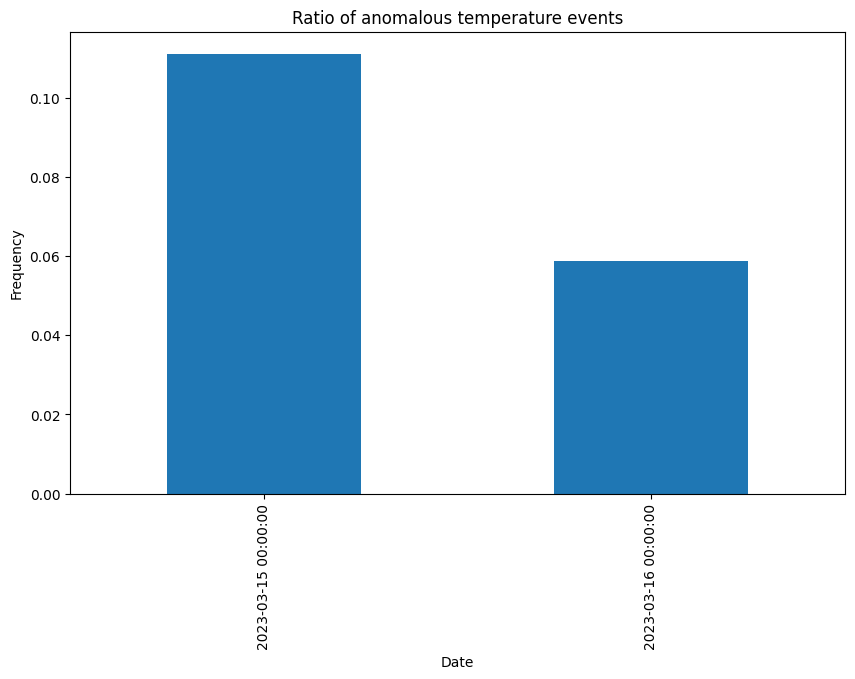

In [13]:
(
    prepare_data(pd.read_csv("../data/scenarios.csv"))
    .pipe(check_temperature_anomaly)
    .query("`TemperatureAnomaly` == 1")
    .groupby(["Date"])["TemperatureAnomaly"]
    .agg(["sum"])
    .merge(
        prepare_data(pd.read_csv("../data/scenarios.csv"))
        .groupby(["Date"])["Temperature"]
        .agg(["count"]),
        on="Date",
        how="left"
    )
    .reset_index()
    .assign(
        **{
            "Percentage": lambda df_: df_["sum"] / df_["count"]
        }
    )
    .plot(
        kind="bar",
        x="Date",
        y="Percentage",
        xlabel="Date", 
        ylabel="Frequency",
        legend=False,
        figsize=(10,6),
        title="Ratio of anomalous temperature events"
    )
    # .transform("sum")
    # .query("'2023-02-21' == `Date`")
)
plt.show()

### 7.3 Anomalous door events
Results show that anomalous door events are observed at 2 specific dates with % of records concerned between 6% and 11%.

They happened for same events as anomalous temperature events 

In [14]:
(
    prepare_data(pd.read_csv("../data/scenarios.csv"))
    .pipe(
        check_doors_anomaly, 
        coordinates={"LatitudeDeparture": 12.67214, "LongitudeDeparture": 108.06884, "LatitudeArrival": 10.38960, "LongitudeArrival": 107.08450},
        tolerance=0.000005
    )
    .query("`DoorsAnomaly` == 1")
    .groupby(["Date"])["DoorsAnomaly"]
    .agg(["sum"])
    .merge(
        prepare_data(pd.read_csv("../data/scenarios.csv"))
        .groupby(["Date"])["Light"]
        .agg(["count"]),
        on="Date",
        how="left"
    )
    .reset_index()
    .assign(
        **{
            "Percentage": lambda df_: df_["sum"] / df_["count"]
        }
    )
    # .plot(
    #     kind="bar",
    #     x="Date",
    #     y="Percentage",
    #     xlabel="Date", 
    #     ylabel="Frequency",
    #     legend=False,
    #     figsize=(10,6),
    #     title="Ratio of anomalous door events"
    # )
    # .transform("sum")
    # .query("'2023-02-21' == `Date`")
)
# plt.show()

Date  sum  count  Percentage
0 2023-03-15    5     45    0.111111
1 2023-03-16    5     85    0.058824

### 7.4 Catastrophic anomalous events
None of these events observed

In [15]:
(
    prepare_data(pd.read_csv("../data/scenarios.csv"))
    .pipe(check_catastrophic_anomaly)
    .query("`CatastrophicAnomaly` == 1")
)

Empty DataFrame
Columns: [ID, Datetime, Date, Time, TimeMinutes, Hour, Minute, Latitude, Longitude, Speed, Temperature, Light, CatastrophicAnomaly]
Index: []

### 7.5 Compiling rule-based anomalous events
In order to help Transportico in the monitoring of anomalous events, results are aggregated by date.

In this way, the client can have a first table giving per day the number of anomalous events detected for each type.

If the client wishes to have detailed results for each day (i.e which specific event is concerned at a specific day), a second table is proposed.

Below are the two tables

SpeedAnomaly  TemperatureAnomaly  DoorsAnomaly  \
Date                                                         
2023-01-01             0                   0             0   
2023-01-02             0                   0             0   
2023-01-03             0                   0             0   
2023-01-04             0                   0             0   
2023-01-05             0                   0             0   
...                  ...                 ...           ...   
2023-03-27             0                   0             0   
2023-03-28             0                   0             0   
2023-03-29             0                   0             0   
2023-03-30             0                   0             0   
2023-03-31            31                   0             0   

            CatastrophicAnomaly  
Date                             
2023-01-01                    0  
2023-01-02                    0  
2023-01-03                    0  
2023-01-04                    0  
2023-01-05                    0  
...                         ...  
2023-03-27                    0  
2023-03-28                    0  
2023-03-29                    0  
2023-03-30                    0  
2023-03-31                    0  

[83 rows x 4 columns]

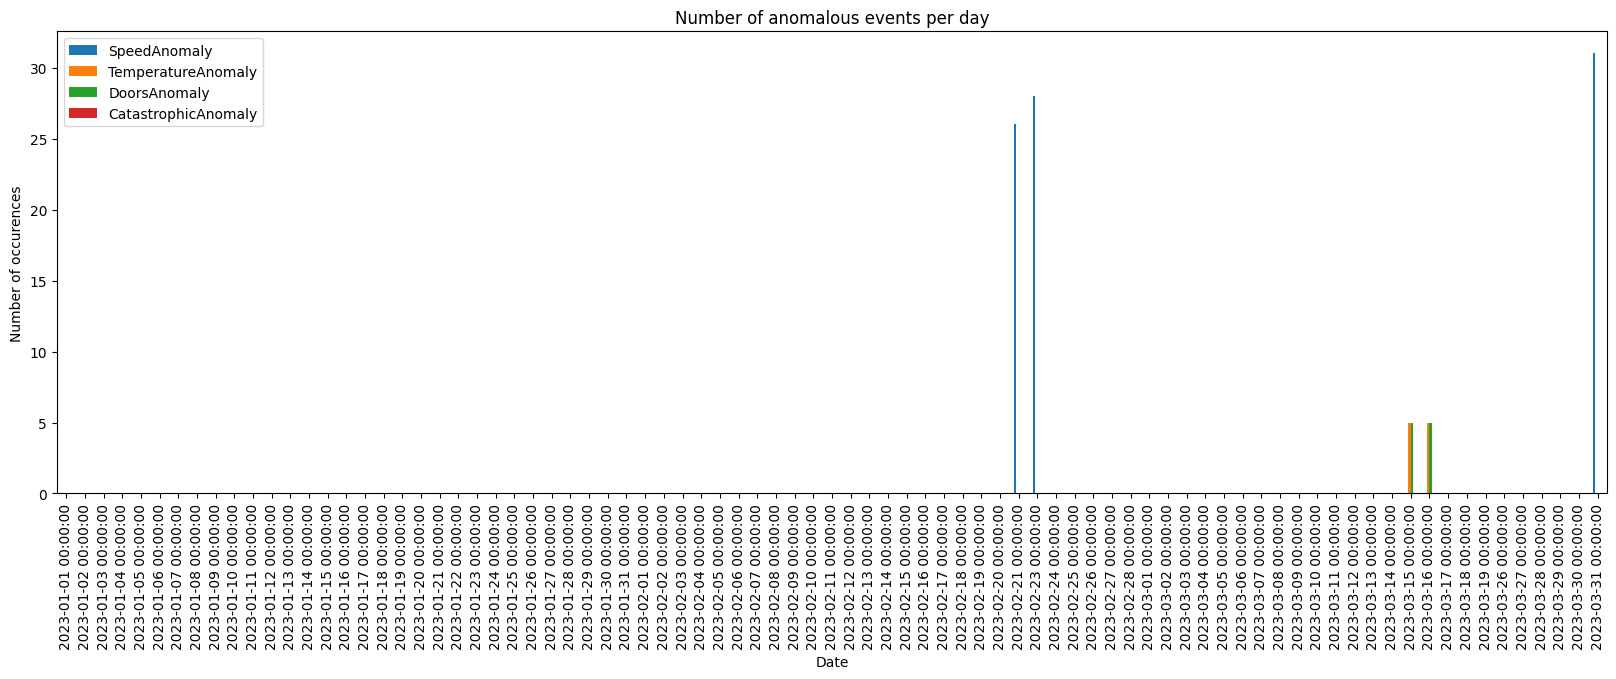

In [16]:
## Table 1
(
    prepare_data(pd.read_csv("../data/scenarios.csv"))
    .pipe(check_speed_anomaly)
    .pipe(check_temperature_anomaly)
    .pipe(
        check_doors_anomaly, 
        coordinates={"LatitudeDeparture": 12.67214, "LongitudeDeparture": 108.06884, "LatitudeArrival": 10.38960, "LongitudeArrival": 107.08450},
        tolerance=0.000005
    )
    .pipe(check_catastrophic_anomaly)
    .groupby(["Date"])[["SpeedAnomaly", "TemperatureAnomaly", "DoorsAnomaly", "CatastrophicAnomaly"]]
    .agg(["sum"])
    .droplevel(1, axis=1)
    .pipe(lambda df_: display(df_) or df_)
    .plot(
        kind="bar",
        xlabel="Date", 
        ylabel="Number of occurences",
        figsize=(20,6),
        title="Number of anomalous events per day"
    )
)
plt.show()

In [17]:
## Table 2
(
    prepare_data(pd.read_csv("../data/scenarios.csv"))
    .pipe(check_speed_anomaly)
    .pipe(check_temperature_anomaly)
    .pipe(
        check_doors_anomaly, 
        coordinates={"LatitudeDeparture": 12.67214, "LongitudeDeparture": 108.06884, "LatitudeArrival": 10.38960, "LongitudeArrival": 107.08450},
        tolerance=0.000005
    )
    .pipe(check_catastrophic_anomaly)
    .pipe(error_counts)
    # .query("`MultipleAnomalies` == 1")
    # .query("`SpeedAnomaly` == 1")
    # .query("'2023-03-16' == `Date`")
    # .groupby(["Date"])["SpeedAnomaly"]
    # .transform("sum")
)

ID            Datetime       Date      Time  \
0     xrlYlV1Pcv_vO_8n4JPyi 2023-01-01 14:00:00 2023-01-01  14:00:00   
1     dkA2V7_H1L-ZewTbeJbQP 2023-01-01 14:13:30 2023-01-01  14:13:30   
2     sfUc0dftAes27cZZ4112_ 2023-01-01 14:27:00 2023-01-01  14:27:00   
3     KLECMdIVRtZ6Yqs2lgWsN 2023-01-01 14:40:30 2023-01-01  14:40:30   
4     ZMiTvOwYlM3bNEgkVy47p 2023-01-01 14:54:00 2023-01-01  14:54:00   
...                     ...                 ...        ...       ...   
2200  EuPgSWmLUnTNWUsrogwW8 2023-03-31 22:10:54 2023-03-31  22:10:54   
2201  A0UuE-SYVjw-tW1kBGgqT 2023-03-31 22:20:43 2023-03-31  22:20:43   
2202  AiNNqxc5csIY6mjs4Lm8Q 2023-03-31 22:30:32 2023-03-31  22:30:32   
2203  2owKdI7zpINnlIUGChvJ0 2023-03-31 22:40:21 2023-03-31  22:40:21   
2204  G8aLwFkqQWKz8cQTYwYHk 2023-03-31 22:50:10 2023-03-31  22:50:10   

      TimeMinutes  Hour  Minute  Latitude  Longitude  Speed  Temperature  \
0             840    14       0  12.67214  108.06884   0.00         5.50   
1             853    14      13  12.65841  108.03907  54.95         2.04   
2             867    14      27  12.61997  107.95092  47.81         2.96   
3             880    14      40  12.58494  107.87112  60.87         2.45   
4             894    14      54  12.54409  107.79773  43.06         2.17   
...           ...   ...     ...       ...        ...    ...          ...   
2200         1330    22      10  10.48768  107.16279  51.93         2.04   
2201         1340    22      20  10.51021  107.09660  37.26         0.01   
2202         1350    22      30  10.43127  107.15820  36.52         4.05   
2203         1360    22      40  10.39718  107.11183  86.67         3.50   
2204         1370    22      50  10.38960  107.08450   0.00         5.60   

      Light  SpeedAnomaly  TemperatureAnomaly  DoorsAnomaly  \
0       200             0                   0             0   
1         0             0                   0             0   
2         0             0                   0             0   
3         0             0                   0             0   
4         0             0                   0             0   
...     ...           ...                 ...           ...   
2200      0             0                   0             0   
2201      0             0                   0             0   
2202      0             0                   0             0   
2203      0             1                   0             0   
2204    180             0                   0             0   

      CatastrophicAnomaly  AnyAnomaly  MultipleAnomalies  
0                       0           0                  0  
1                       0           0                  0  
2                       0           0                  0  
3                       0           0                  0  
4                       0           0                  0  
...                   ...         ...                ...  
2200                    0           0                  0  
2201                    0           0                  0  
2202                    0           0                  0  
2203                    0           1                  0  
2204                    0           0                  0  

[3415 rows x 18 columns]

The following function allows to get the dataframe of Table 1 from the dataframe of Table 2

In [18]:
def aggregate_rule_anomalies(data: pd.DataFrame) -> pd.DataFrame:
    """TODO describe function

        :param data:
        :returns:

    """
    return(
        data.copy()
        .groupby(["Date"])[["SpeedAnomaly", "TemperatureAnomaly", "DoorsAnomaly", "CatastrophicAnomaly"]]
        .agg(["sum"])
        .droplevel(1, axis=1)
        .reset_index()
        .rename(
            columns={
                "SpeedAnomaly": "NumberSpeedAnomaly",
                "TemperatureAnomaly": "NumberTemperatureAnomaly",
                "DoorsAnomaly": "NumberDoorsAnomaly",
                "CatastrophicAnomaly": "NumberCatastrophicAnomaly"
            }
        )
        .astype(
            {
                "NumberSpeedAnomaly": "int",
                "NumberTemperatureAnomaly": "int",
                "NumberDoorsAnomaly": "int",
                "NumberCatastrophicAnomaly": "int"
            }
        )
    )

## 8. Exploring "unknowns" using EDA
The objective here is to go further in the analysis and identify some anomalous behaviours using EDA.

The checks performed will be at date level to augment Table 1 above.

Each check is performed using a function that takes as input the transformed dataframe and return a the dataframe with a new column filled with 1 (Anomalous event) or 0 (Normal event)

### 8.1 Anomalous number of records
In 6.1, the reference number of records identified was 40 per date (94% of dates). 

```Dates with number of records > 40 can be flagged as anomalous```

In this section we will perform detailed analysis of each anomalous record date to understand what makes them anomalous

The following function allows adding results of record number check to Table 1

In [19]:
def check_number_of_record_anomaly(data: pd.DataFrame, initdf: pd.DataFrame) -> pd.DataFrame:
    """Add column with anomalies detected on record data

        :param data: input DataFrame
        :param initdf: initial transformed DataFrame
        :returns: DataFrame with additional column with results of check

    """
    tmp_df = (
        initdf
        .groupby(["Date"])["ID"]
        .agg(["count"])
        .reset_index()
        .assign(**{"count": lambda df_: df_["count"].apply(lambda x: True if x > 40 else False)})
        .rename(
            columns={
            "count": "TotalRecordsAnomaly"})
    )
    
    return (
        data.copy()
        .merge(
            tmp_df,
            on="Date",
            how="left"
        )
    )

Results below highlight 5 dates for which the number of records > 40 with corresponding number of records and trip duration

In [20]:
(
    prepare_data(pd.read_csv("../data/scenarios.csv"))
    .pipe(check_speed_anomaly)
    .pipe(check_temperature_anomaly)
    .pipe(
        check_doors_anomaly, 
        coordinates={"LatitudeDeparture": 12.67214, "LongitudeDeparture": 108.06884, "LatitudeArrival": 10.38960, "LongitudeArrival": 107.08450},
        tolerance=0.000005
    )
    .pipe(check_catastrophic_anomaly)
    .pipe(aggregate_rule_anomalies)
    .pipe(
        check_number_of_record_anomaly, 
        initdf=prepare_data(pd.read_csv("../data/scenarios.csv"))
    )
    .query("`TotalRecordsAnomaly` == 1")
    .merge(
        prepare_data(pd.read_csv("../data/scenarios.csv"))
        .groupby(["Date"])["ID"]
        .agg(["count"]),
        on="Date",
        how="left"
    )
    .rename(
        columns={
        "count": "TotalRecords"
        }
    )
    .merge(
        prepare_data(pd.read_csv("../data/scenarios.csv"))
        .groupby(["Date"])[["Datetime"]]
        .agg(["first", "last"])
        .droplevel(0, axis=1)
        .assign(
            **{
                "TripDuration": lambda df_: (df_["last"] - df_["first"]).dt.total_seconds() / 60
            }
        ),
        on="Date",
        how="left"
    )
    # .query("`duration` != 526.5")
    .drop(
        ["first", "last"], axis=1
    )
)

Date  NumberSpeedAnomaly  NumberTemperatureAnomaly  \
0 2023-02-21                  26                         0   
1 2023-02-23                  28                         0   
2 2023-03-15                   0                         5   
3 2023-03-16                   0                         5   
4 2023-03-31                  31                         0   

   NumberDoorsAnomaly  NumberCatastrophicAnomaly  TotalRecordsAnomaly  \
0                   0                          0                 True   
1                   0                          0                 True   
2                   5                          0                 True   
3                   5                          0                 True   
4                   0                          0                 True   

   TotalRecords  TripDuration  
0            55    530.166667  
1            55    530.166667  
2            45    528.000000  
3            85    528.000000  
4            55    530.166667

The trip duration for reference dates (those with 40 records) is 526.5 minutes

Dates for which the number of records is anomalous correspond to those for which the trip duration is also anomalous.

The number of records increases with trip duration 

#### Trips with 55 records
For these trips, speed limit has been exceeded up to 50% of the trip and a detailed analysis highlights an anomalous route for the truck

In [21]:
def compare_trip_position(data: pd.DataFrame, dates: list) -> None:
    """TODO describe function

        :param data:
        :returns:

    """    
    fig, ax = plt.subplots(figsize=(12,6))
    for date in dates:
        ax.plot(
            data.query("@date == `Date`")["Latitude"], 
            data.query("@date == `Date`")["Longitude"], 
            label=date
        )
    ax.set_xlabel("Latitude")
    ax.set_ylabel("Longitude")
    ax.legend()
    plt.show()

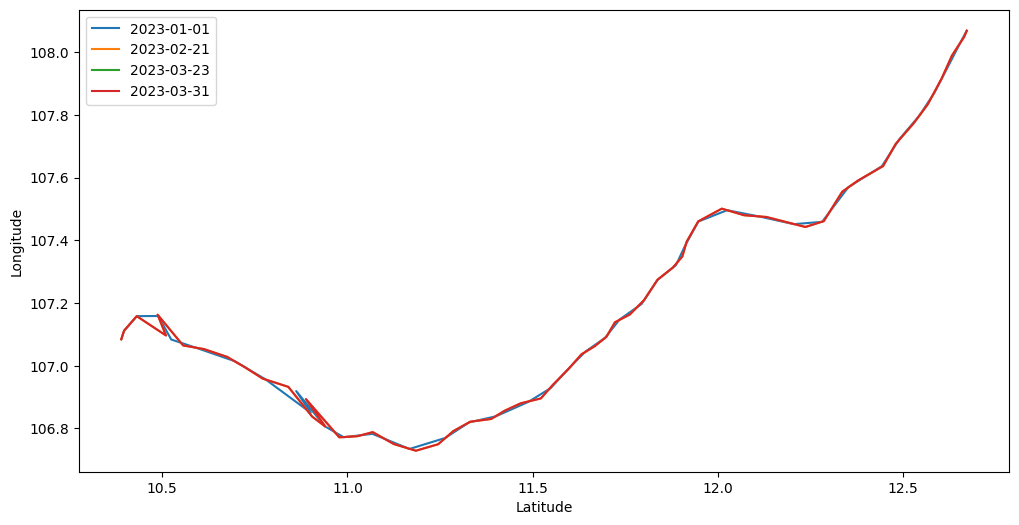

In [22]:
compare_trip_position(
    data=prepare_data(pd.read_csv("../data/scenarios.csv")), 
    dates=["2023-01-01", "2023-02-21", "2023-03-23", "2023-03-31"],
)

#### Trip with 45 records
For this trip, 5 events recorded that trailer doors have been opened and the temperature went above 6°C.

A detailed analysis highlights that the truck has stopped in the course of the trip (Speed = 0)

In [23]:
def compare_trip_coordinate(data: pd.DataFrame, dates: list) -> None:
    """TODO describe function

        :param data:
        :returns:

    """    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
    for date in dates:
        ax1.plot(
            [i for i in range(data.query("@date == `Date`").shape[0])],
            # data.query("@date == `Date`")["Latitude"], 
            data.query("@date == `Date`")["Latitude"], 
            label=date
        )
        ax2.plot(
        [i for i in range(data.query("@date == `Date`").shape[0])],
        # data.query("@date == `Date`")["Latitude"], 
        data.query("@date == `Date`")["Longitude"], 
        label=date
        )        
    ax1.set_ylabel("Latitude")
    ax2.set_ylabel("Longitude")
    ax1.legend()
    ax2.legend()
    plt.show()

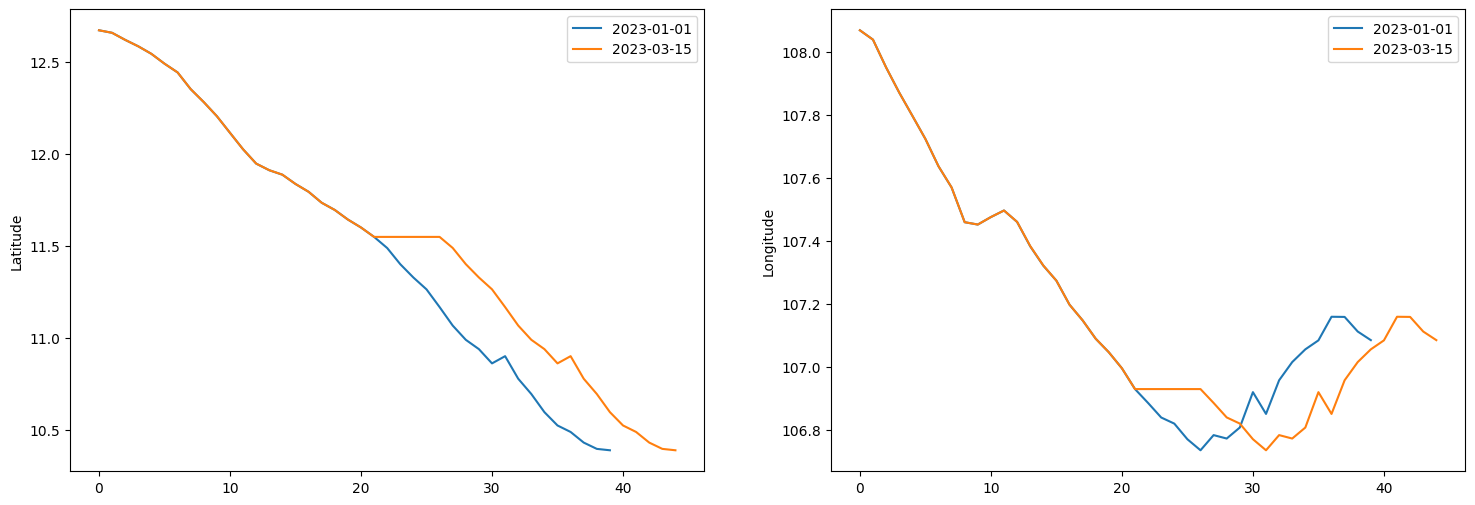

In [24]:
compare_trip_coordinate(
    data=prepare_data(pd.read_csv("../data/scenarios.csv")), 
    dates=["2023-01-01", "2023-03-15"],
)

#### Trip with 85 records
For this trip, a detailed analysis shows that it actually consists of 2 different trips:
- One reference trip with 40 records and reference measures
- One trip with 45 records.

This could mean a special date with two trucks BUT as they are no other similar dates, a meaning could also be a erroneous date, i.e. one of both trips corresponds to another date

### 8.2 Absence of records
Some dates are missing in the list of events

```Dates without records can be flagged as anomalous```

The function below adds a corresponding column with results of check


In [25]:
def check_no_record_anomaly(data: pd.DataFrame) -> pd.DataFrame:
    """Add column with anomalies detected on non existing records

        :param data: input DataFrame
        :returns: DataFrame with additional column with results of check

    """

    return (
        data.copy()
        .merge(
            pd.DataFrame({"Date": pd.date_range(start="1/1/2023", end="31/03/2023")}),
            on="Date",
            how="right"
        )
        .assign(
            **{
                "NoRecordAnomaly": lambda df_: df_["TotalRecordsAnomaly"].apply(lambda x: True if pd.isna(x) else False)
            }
        )
    )

Results show that 7 dates have no records with 6 consecutive dates in March

In [26]:
(
    prepare_data(pd.read_csv("../data/scenarios.csv"))
    .pipe(check_speed_anomaly)
    .pipe(check_temperature_anomaly)
    .pipe(
        check_doors_anomaly, 
        coordinates={"LatitudeDeparture": 12.67214, "LongitudeDeparture": 108.06884, "LatitudeArrival": 10.38960, "LongitudeArrival": 107.08450},
        tolerance=0.000005
    )
    .pipe(check_catastrophic_anomaly)
    .pipe(aggregate_rule_anomalies)
    .pipe(
        check_number_of_record_anomaly, 
        initdf=prepare_data(pd.read_csv("../data/scenarios.csv"))
    )
    .pipe(check_no_record_anomaly)
    .query("`NoRecordAnomaly` == 1")
)

/tmp/ipykernel_6318/2047170340.py:12: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  pd.DataFrame({"Date": pd.date_range(start="1/1/2023", end="31/03/2023")}),


Date  NumberSpeedAnomaly  NumberTemperatureAnomaly  \
52 2023-02-22                 NaN                       NaN   
78 2023-03-20                 NaN                       NaN   
79 2023-03-21                 NaN                       NaN   
80 2023-03-22                 NaN                       NaN   
81 2023-03-23                 NaN                       NaN   
82 2023-03-24                 NaN                       NaN   
83 2023-03-25                 NaN                       NaN   

    NumberDoorsAnomaly  NumberCatastrophicAnomaly TotalRecordsAnomaly  \
52                 NaN                        NaN                 NaN   
78                 NaN                        NaN                 NaN   
79                 NaN                        NaN                 NaN   
80                 NaN                        NaN                 NaN   
81                 NaN                        NaN                 NaN   
82                 NaN                        NaN                 NaN   
83                 NaN                        NaN                 NaN   

    NoRecordAnomaly  
52             True  
78             True  
79             True  
80             True  
81             True  
82             True  
83             True

### 8.3 Compiling all anomaly data
Update of Table 1 and Table 2 with complete data


In [27]:
# Table 1
(
    prepare_data(pd.read_csv("../data/scenarios.csv"))
    .pipe(check_speed_anomaly)
    .pipe(check_temperature_anomaly)
    .pipe(
        check_doors_anomaly, 
        coordinates={"LatitudeDeparture": 12.67214, "LongitudeDeparture": 108.06884, "LatitudeArrival": 10.38960, "LongitudeArrival": 107.08450},
        tolerance=0.000005
    )
    .pipe(check_catastrophic_anomaly)
    .pipe(aggregate_rule_anomalies)
    .pipe(
        check_number_of_record_anomaly, 
        initdf=prepare_data(pd.read_csv("../data/scenarios.csv"))
    )
    .pipe(check_no_record_anomaly)
    # .dtypes
    .pipe(lambda df_: df_.to_csv("../data/table1.csv", index=False))
)

/tmp/ipykernel_6318/2047170340.py:12: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  pd.DataFrame({"Date": pd.date_range(start="1/1/2023", end="31/03/2023")}),


In [28]:
# Table 2
(
    prepare_data(pd.read_csv("../data/scenarios.csv"))
    .pipe(check_speed_anomaly)
    .pipe(check_temperature_anomaly)
    .pipe(
        check_doors_anomaly, 
        coordinates={"LatitudeDeparture": 12.67214, "LongitudeDeparture": 108.06884, "LatitudeArrival": 10.38960, "LongitudeArrival": 107.08450},
        tolerance=0.000005
    )
    .pipe(check_catastrophic_anomaly)
    .pipe(aggregate_rule_anomalies)
    .pipe(
        check_number_of_record_anomaly, 
        initdf=prepare_data(pd.read_csv("../data/scenarios.csv"))
    )
    .pipe(check_no_record_anomaly)
    .merge(
        prepare_data(pd.read_csv("../data/scenarios.csv"))
        .pipe(check_speed_anomaly)
        .pipe(check_temperature_anomaly)
        .pipe(
            check_doors_anomaly, 
            coordinates={"LatitudeDeparture": 12.67214, "LongitudeDeparture": 108.06884, "LatitudeArrival": 10.38960, "LongitudeArrival": 107.08450},
            tolerance=0.000005
        )
        .pipe(check_catastrophic_anomaly)
        .pipe(error_counts),
        on="Date",
        how="outer"
    )
    # .query("`NoRecordAnomaly` == 1")
    .pipe(lambda df_: df_.to_csv("../data/table2.csv", index=False))
)

/tmp/ipykernel_6318/2047170340.py:12: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  pd.DataFrame({"Date": pd.date_range(start="1/1/2023", end="31/03/2023")}),


## 9. Exploring "unknowns" using statistic methods and ML
The objective here is to go further in the analysis and identify some anomalous behaviours using advanced techniques.

Geo-based analysis

Time-based analysis

>```Disclaimer: These first two analysis are just another way to get to the results already obtained above but with more visualization (using plotly)```

Statistic methods

Supervised and unsupervised ML

Anomaly detection on time series

### 9.1 Geo-based + Time-based

In [29]:
table2 = (
    prepare_data(pd.read_csv("../data/scenarios.csv"))
    .pipe(check_speed_anomaly)
    .pipe(check_temperature_anomaly)
    .pipe(
        check_doors_anomaly, 
        coordinates={"LatitudeDeparture": 12.67214, "LongitudeDeparture": 108.06884, "LatitudeArrival": 10.38960, "LongitudeArrival": 107.08450},
        tolerance=0.000005
    )
    .pipe(check_catastrophic_anomaly)
    .pipe(aggregate_rule_anomalies)
    .pipe(
        check_number_of_record_anomaly, 
        initdf=prepare_data(pd.read_csv("../data/scenarios.csv"))
    )
    .pipe(check_no_record_anomaly)
    .merge(
        prepare_data(pd.read_csv("../data/scenarios.csv"))
        .pipe(check_speed_anomaly)
        .pipe(check_temperature_anomaly)
        .pipe(
            check_doors_anomaly, 
            coordinates={"LatitudeDeparture": 12.67214, "LongitudeDeparture": 108.06884, "LatitudeArrival": 10.38960, "LongitudeArrival": 107.08450},
            tolerance=0.000005
        )
        .pipe(check_catastrophic_anomaly)
        .pipe(error_counts),
        on="Date",
        how="outer"
    )
)

/tmp/ipykernel_6318/2047170340.py:12: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  pd.DataFrame({"Date": pd.date_range(start="1/1/2023", end="31/03/2023")}),


### 9.1.1 Geo analysis

In [30]:
fig = go.Figure(
    go.Scattermapbox(
        name="Route 1",
        mode="markers",
        lon=table2.query("`Date` == '2023-01-01'")["Longitude"],
        lat=table2.query("`Date` == '2023-01-01'")["Latitude"],
        marker={"size": 10},
    )
)

fig.add_trace(
    go.Scattermapbox(
        name="Route 2",
        mode="markers",
        lon=table2.query("`Date` == '2023-01-11'")["Longitude"],
        lat=table2.query("`Date` == '2023-01-11'")["Latitude"],
        marker={"size": 10},
    )
)

fig.update_layout(
    margin={"l": 0, "t": 0, "b": 0, "r": 0},
    mapbox={
        "center": {"lon": 107, "lat": 107},
        "style": "open-street-map",
        "center": {"lon": 107.5, "lat": 11.5},
        "zoom": 6.5,
    },
)

fig.show()

>```The trip is from Buôn Ma Thuôt to Vung Tàu```

>```Two different routes are used by trucks. One trip goes through weird GPS positions (no routes identified)```

In [31]:
table2.query("`Latitude` == 11.82833")

Date  NumberSpeedAnomaly  NumberTemperatureAnomaly  \
421 2023-01-11                 0.0                       0.0   

     NumberDoorsAnomaly  NumberCatastrophicAnomaly TotalRecordsAnomaly  \
421                 0.0                        0.0               False   

     NoRecordAnomaly                     ID            Datetime      Time  \
421            False  XzbolnxJCqGexP5_BeyMj 2023-01-11 18:43:30  18:43:30   

     ...  Longitude  Speed  Temperature  Light  SpeedAnomaly  \
421  ...  106.89249   23.1         2.81    0.0           0.0   

     TemperatureAnomaly  DoorsAnomaly  CatastrophicAnomaly  AnyAnomaly  \
421                 0.0           0.0                  0.0         0.0   

     MultipleAnomalies  
421                0.0  

[1 rows x 24 columns]

#### Light

In [32]:
fig = go.Figure(
    go.Scattermapbox(
        name="Light = 0",
        mode="markers",
        lon=table2.query("Light == 0")["Longitude"],
        lat=table2.query("Light == 0")["Latitude"],
        marker={"size": 10},
    )
)


fig.add_trace(
    go.Scattermapbox(
        name="Light = 200",
        mode="markers",
        lon=table2.query("Light == 200")["Longitude"],
        lat=table2.query("Light == 200")["Latitude"],
        marker={"size": 20},
    )
)

fig.add_trace(
    go.Scattermapbox(
        name="Light = 180",
        mode="markers",
        lon=table2.query("Light == 180")["Longitude"],
        lat=table2.query("Light == 180")["Latitude"],
        marker={"size": 20},
    )
)

fig.update_layout(
    margin={"l": 0, "t": 0, "b": 0, "r": 0},
    mapbox={
        "center": {"lon": 107, "lat": 107},
        "style": "open-street-map",
        "center": {"lon": 107.5, "lat": 11.5},
        "zoom": 6.5,
    },
)

fig.show()

>```Lights are mostly on at departure and arrival```

>```Two positions in the middle of the trip show lights on in the trailer```

#### Speed

In [33]:
fig = go.Figure(
    go.Scattermapbox(
        name="Speed = 0",
        mode="markers",
        lon=table2.query("Speed == 0")["Longitude"],
        lat=table2.query("Speed == 0")["Latitude"],
        marker={"size": 20},
    )
)

fig.add_trace(
    go.Scattermapbox(
        name="Speed <= 40",
        mode="markers",
        lon=table2.query("Speed <= 40")["Longitude"],
        lat=table2.query("Speed <= 40")["Latitude"],
        marker={"size": 10},
        text=table2.query("Speed <= 40")["Datetime"]
    )
)

fig.add_trace(
    go.Scattermapbox(
        name="40 < Speed <= 80",
        mode="markers",
        lon=table2.query("Speed > 40 and Speed <= 80")["Longitude"],
        lat=table2.query("Speed > 40 and Speed <= 80")["Latitude"],
        marker={"size": 10},
    )
)



fig.add_trace(
    go.Scattermapbox(
        name="Speed > 80",
        mode="markers",
        lon=table2.query("Speed > 80")["Longitude"],
        lat=table2.query("Speed > 80")["Latitude"],
        marker={"size": 10},
        text=table2.query("Speed > 80")["Datetime"]
    )
)

fig.update_layout(
    margin={"l": 0, "t": 0, "b": 0, "r": 0},
    mapbox={
        "center": {"lon": 107, "lat": 107},
        "style": "open-street-map",
        "center": {"lon": 107.5, "lat": 11.5},
        "zoom": 6.5,
    },
)

fig.show()

>```The two positions with lights on in the middle of the trip correspond to positions for which the truck is stopped```

>```Anomalies on speed are observed only on the main road.```

#### Temperature

In [34]:
fig = go.Figure(
    go.Scattermapbox(
        name="Temperature <= 6",
        mode="markers",
        lon=table2.query("Temperature <= 6")["Longitude"],
        lat=table2.query("Temperature <= 6")["Latitude"],
        marker={"size": 10},
    )
)

fig.add_trace(
    go.Scattermapbox(
        name="Temperature > 6",
        mode="markers",
        lon=table2.query("Temperature > 6")["Longitude"],
        lat=table2.query("Temperature > 6")["Latitude"],
        marker={"size": 20},
    )
)

fig.update_layout(
    margin={"l": 0, "t": 0, "b": 0, "r": 0},
    mapbox={
        "center": {"lon": 107, "lat": 107},
        "style": "open-street-map",
        "center": {"lon": 107.5, "lat": 11.5},
        "zoom": 6.5,
    },
)

fig.show()

>```The two positions with lights on in the middle of the trip correspond to positions showing temperature anomalies```

#### Weird points

In [35]:
fig = go.Figure(
    go.Scattermapbox(
        mode="lines+markers",
        lon=table2.query("Date == '2023-01-01'")["Longitude"],
        lat=table2.query("Date == '2023-01-01'")["Latitude"],
        marker={"size": 5},
    )
)

fig.update_layout(
    margin={"l": 0, "t": 0, "b": 0, "r": 0},
    mapbox={
        "center": {"lon": 107, "lat": 107},
        "style": "open-street-map",
        "center": {"lon": 107.5, "lat": 11.5},
        "zoom": 6.5,
    },
)

fig.show()

>```Weird routes ?```

>```GPS issues ?```

### 9.1.2 Time analysis

#### Speed

In [36]:
px.density_heatmap(
    table2, 
    x="Date", 
    y="TimeMinutes", 
    z="Speed", 
    histfunc="max", 
    nbinsx=100
)

>```Three dates with speed anomalies```

#### Light

In [37]:
px.density_heatmap(
    table2, 
    x="Date", 
    y="TimeMinutes", 
    z="Light", 
    histfunc="max", 
    nbinsx=100
)

#### Temperature

In [38]:
px.density_heatmap(
    table2, 
    x="Date", 
    y="TimeMinutes", 
    z="Temperature", 
    histfunc="max", 
    nbinsx=100
)

#### Latitude

In [39]:
px.density_heatmap(
    table2, 
    x="Date", 
    y="TimeMinutes", 
    z="Latitude", 
    histfunc="max", 
    nbinsx=100
)

## 10. Summary of all analysis from Sections 6. 7. 8. 9.

Below is a summary of all dates when anomalous events (rule-based or EDA-based) have been spotted and the explanation of corresponding events

>```2023-01-11 --> Abnormal route taken```

>```2023-02-21 --> Truck driving too fast (to catch up delay due to detour taken ?)```

>```2023-02-22 --> No data recorded```

>```2023-02-23 --> Truck driving too fast (to catch up delay due to detour taken ?)```

>```2023-03-15 --> Truck stopped in the middle of the trip and trailer doors have been opened```

>```2023-03-16 --> Truck stopped in the middle of the trip and trailer doors have been opened```

>```2023-03-16 --> 2 trips recorded```

>```2023-03-20 --> No data recorded```

>```2023-03-21 --> No data recorded```

>```2023-03-22 --> No data recorded```

>```2023-03-23 --> No data recorded```

>```2023-03-24 --> No data recorded```

>```2023-03-25 --> No data recorded```

>```2023-03-31 --> Truck driving too fast (to catch up delay due to detour taken ?)```

## 11. Statistical analysis

Without rules, a way to spot anomalies can be by applying statistical methods using percentiles.

The percentile method is based on identifying data points that fall outside a specific percentile range. 

### 11.1 IQR (Inter-quartile range)
The interquartile range (IQR) method is based on the range between the first and third quartiles of the dataset. In this method, data points that fall outside a certain IQR range are considered anomalies

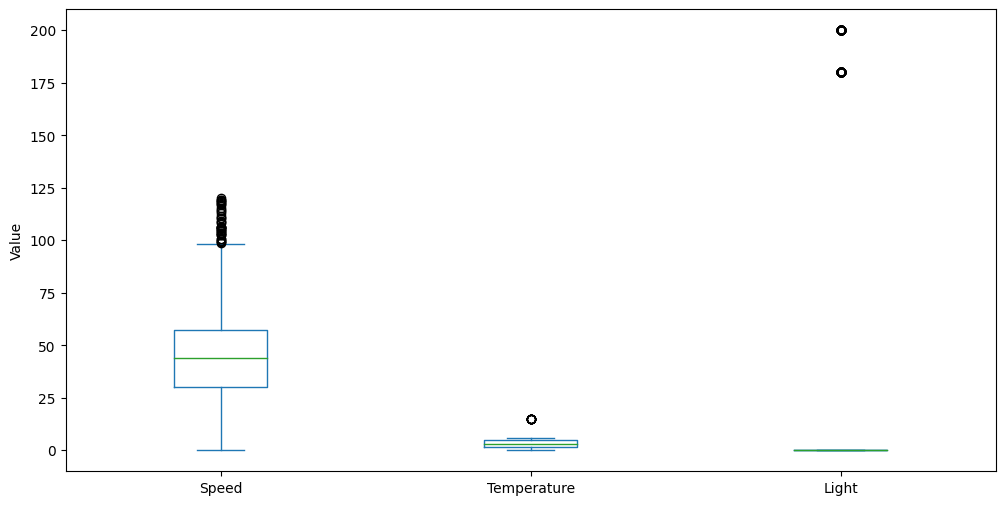

In [40]:
(
    prepare_data(pd.read_csv("../data/scenarios.csv"))[["Speed", "Temperature", "Light"]]
    .plot(
        kind="box", 
        figsize=(12,6),
        ylabel="Value"
    )
)
plt.show()

### 11.2 Percentiles

In [41]:
(
    table2[["Latitude", "Longitude", "Speed", "Temperature", "Light"]]
    .dropna()
    .describe()
    .T.assign(
        **{
            "1%": np.quantile(table2[["Latitude", "Longitude", "Speed", "Temperature", "Light"]].dropna().T, 0.1, axis=1),
            "5%": np.quantile(table2[["Latitude", "Longitude", "Speed", "Temperature", "Light"]].dropna().T, 0.5, axis=1),
            "95%": np.quantile(table2[["Latitude", "Longitude", "Speed", "Temperature", "Light"]].dropna().T, 0.95, axis=1),
            "99%": np.quantile(table2[["Latitude", "Longitude", "Speed", "Temperature", "Light"]].dropna().T, 0.99, axis=1),
        }
    )
)

count        mean        std        min        25%         50%  \
Latitude     3415.0   11.559685   0.715174   10.36712   10.93927   11.600302   
Longitude    3415.0  107.227123   0.374612  106.67792  106.91927  107.111830   
Speed        3415.0   43.779792  19.207316    0.00000   30.24000   44.030000   
Temperature  3415.0    3.153388   1.903512    0.00000    1.58000    3.180000   
Light        3415.0    9.874085  42.175207    0.00000    0.00000    0.000000   

                   75%         max          1%          5%         95%  \
Latitude      12.13146   12.743010   10.524410   11.600302   12.634289   
Longitude    107.46132  108.068844  106.784988  107.111830  107.973165   
Speed         57.47500  119.960000   22.854000   44.030000   68.680000   
Temperature    4.78000   15.000000    0.610000    3.180000    5.730000   
Light          0.00000  200.000000    0.000000    0.000000  180.000000   

                   99%  
Latitude      12.67214  
Longitude    108.06884  
Speed         99.72440  
Temperature    5.94860  
Light        200.00000

## 12. ML techniques

Without rules, a way to spot anomalies can be by applying ML methods.

**Supervised Methods**

Supervised ML algorithms are trained on a labeled dataset that includes both normal and anomalous data points. The algorithms learn to classify data points as either normal or anomalous based on the features of the data. The performance of the algorithm can be evaluated using metrics such as accuracy, precision, recall, and F1-score.

>```In the Transportico exercise, a way to achieved that is to manually label data points of Table 2 and train classification algorithms (KNN, DT, Ensemble methods)```

**Watch out** : This type of dataset is imbalanced (more normal points than anomalous points) and therefore statistical resampling methods (e.g. SMOTE) have to be applied to boost performances


**Unsupervised Methods**

Unsupervised ML based methods for anomaly detection involve training models on a dataset without any labels indicating the presence of anomalies.
KMeans, DBSCAN, LOF (Local Outlier Factor), EE (Elliptic Envelope works with Gaussian distributed dataset)

## 13. Time series

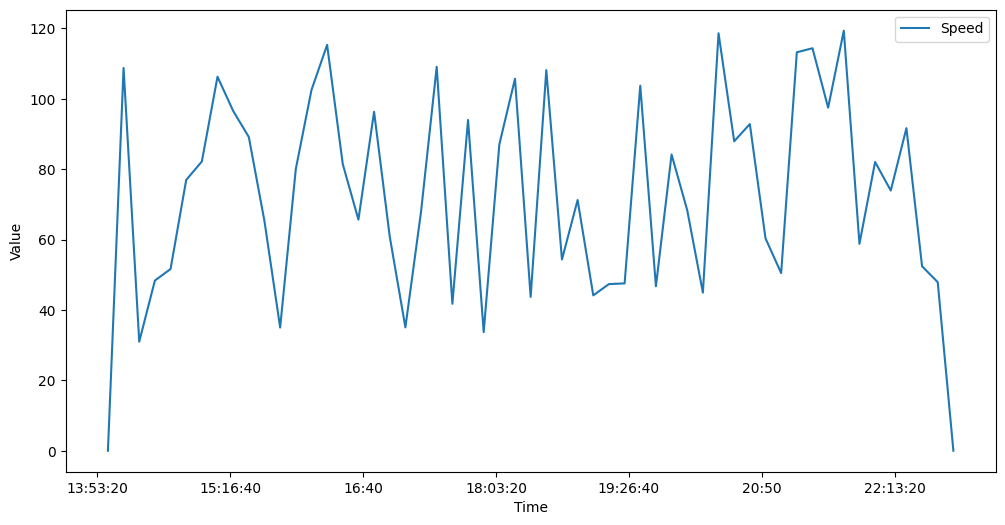

In [42]:
(
    prepare_data(pd.read_csv("../data/scenarios.csv"))
    .query("`Date` == '2023-02-21'")
    .plot(x="Time", y="Speed", figsize=(12,6), ylabel="Value")
)
plt.show()

In [43]:
(
    prepare_data(pd.read_csv("../data/scenarios.csv"))
    # .query("`Date` == '2023-02-21'")
    # .plot(x="Time", y="Speed")
    .pivot_table(values='Speed', index='Date', columns='Time')
    .transpose()
    # .iloc[:, 0:1]
    # .dropna()
    # .plot(figsize=(12,6))
)

Date      2023-01-01  2023-01-02  2023-01-03  2023-01-04  2023-01-05  \
Time                                                                   
14:00:00        0.00        0.00        0.00        0.00        0.00   
14:09:49         NaN         NaN         NaN         NaN         NaN   
14:12:00         NaN         NaN         NaN         NaN         NaN   
14:13:30       54.95       60.74       68.35       49.42       34.46   
14:19:38         NaN         NaN         NaN         NaN         NaN   
...              ...         ...         ...         ...         ...   
22:36:00         NaN         NaN         NaN         NaN         NaN   
22:40:21         NaN         NaN         NaN         NaN         NaN   
22:46:30        0.00        0.00        0.00        0.00        0.00   
22:48:00         NaN         NaN         NaN         NaN         NaN   
22:50:10         NaN         NaN         NaN         NaN         NaN   

Date      2023-01-06  2023-01-07  2023-01-08  2023-01-09  2023-01-10  ...  \
Time                                                                  ...   
14:00:00        0.00        0.00        0.00        0.00        0.00  ...   
14:09:49         NaN         NaN         NaN         NaN         NaN  ...   
14:12:00         NaN         NaN         NaN         NaN         NaN  ...   
14:13:30       60.78       43.92       34.09       55.81       52.81  ...   
14:19:38         NaN         NaN         NaN         NaN         NaN  ...   
...              ...         ...         ...         ...         ...  ...   
22:36:00         NaN         NaN         NaN         NaN         NaN  ...   
22:40:21         NaN         NaN         NaN         NaN         NaN  ...   
22:46:30        0.00        0.00        0.00        0.00        0.00  ...   
22:48:00         NaN         NaN         NaN         NaN         NaN  ...   
22:50:10         NaN         NaN         NaN         NaN         NaN  ...   

Date      2023-03-16  2023-03-17  2023-03-18  2023-03-19  2023-03-26  \
Time                                                                   
14:00:00        0.00        0.00        0.00        0.00         0.0   
14:09:49         NaN         NaN         NaN         NaN         NaN   
14:12:00       55.72         NaN         NaN         NaN         NaN   
14:13:30       32.68       51.43       40.47       54.32        23.4   
14:19:38         NaN         NaN         NaN         NaN         NaN   
...              ...         ...         ...         ...         ...   
22:36:00       43.72         NaN         NaN         NaN         NaN   
22:40:21         NaN         NaN         NaN         NaN         NaN   
22:46:30        0.00        0.00        0.00        0.00         0.0   
22:48:00        0.00         NaN         NaN         NaN         NaN   
22:50:10         NaN         NaN         NaN         NaN         NaN   

Date      2023-03-27  2023-03-28  2023-03-29  2023-03-30  2023-03-31  
Time                                                                  
14:00:00        0.00         0.0        0.00        0.00        0.00  
14:09:49         NaN         NaN         NaN         NaN       99.69  
14:12:00         NaN         NaN         NaN         NaN         NaN  
14:13:30       49.73        25.5       42.87       48.34         NaN  
14:19:38         NaN         NaN         NaN         NaN       60.79  
...              ...         ...         ...         ...         ...  
22:36:00         NaN         NaN         NaN         NaN         NaN  
22:40:21         NaN         NaN         NaN         NaN       86.67  
22:46:30        0.00         0.0        0.00        0.00         NaN  
22:48:00         NaN         NaN         NaN         NaN         NaN  
22:50:10         NaN         NaN         NaN         NaN        0.00  

[130 rows x 83 columns]

In [108]:
tsd = prepare_data(pd.read_csv("../data/scenarios.csv")).assign(**{"Time": lambda df_: df_["Datetime"].dt.time })
fig = go.Figure()
for datet in tsd["Date"].unique():
    fig.add_trace(
        go.Scatter(
            name=str(pd.to_datetime(datet).date()),
            mode="lines+markers",
            y=tsd.query("Date == @datet")["Speed"],
            x=pd.to_datetime(tsd.query("Date == @datet")["Datetime"].dt.time, format="%H:%M:%S"),
            marker={"size": 5},
        )
    )

fig.update_layout(xaxis_tickformat="%H:%M", height=700)#, margin=dict(l=0,r=0,b=0,t=0))
fig.show()